In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2

In [3]:
pip install opencv-python

In [4]:
# share folder path
with open(r"/content/drive/MyDrive/cse493-final/Tufts Dental Database/Segmentation/teeth_bbox.json") as f:
    bboxes = json.load(f)

In [5]:
image_id = bboxes[0]['External ID'].split(".")[0]
image_id

'797'

In [9]:
tooth_bbox = bboxes[24]['Label']['objects'][0]['bounding box']
tooth_bbox

[276, 408, 417, 488]

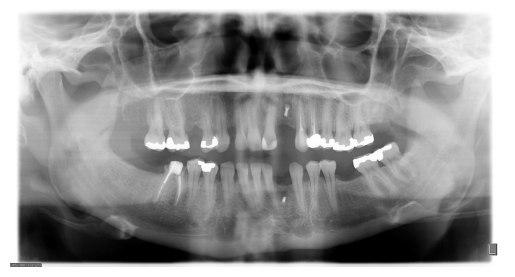

(840, 1615, 3)


In [7]:
import matplotlib.pyplot as plt

# Read the image using matplotlib.image
im = cv2.imread(f"/content/drive/MyDrive/cse493-final/Tufts Dental Database/Radiographs/{952}.JPG")
# Display the image with interactive features (pan/zoom)
plt.figure()
plt.imshow(im)
plt.axis('off')  # Turn off axis labels
plt.show()
print(im.shape)

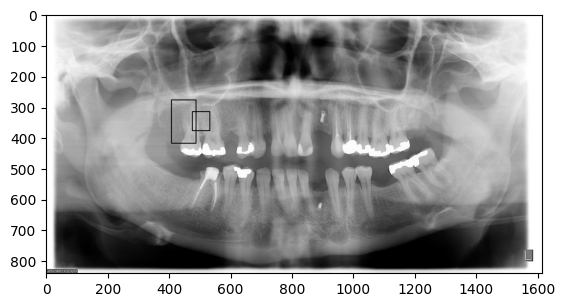

In [10]:
# Check if image is loaded properly
if im is None:
    print("Error: Could not read the image.")
else:
    # Coordinates of the rectangle's top-left and bottom-right corners
    top_left_corner = (tooth_bbox[1], tooth_bbox[0])  # Replace x1, y1 with actual coordinates
    bottom_right_corner = (tooth_bbox[3], tooth_bbox[2])  # Replace x2, y2 with actual coordinates

    # Draw a black rectangle on the image
    cv2.rectangle(im, top_left_corner, bottom_right_corner, 0, 2)

    # Display the image using plt in single-channel grayscale
    plt.imshow(im, cmap='gray')


(-0.5, 56.5, 61.5, -0.5)

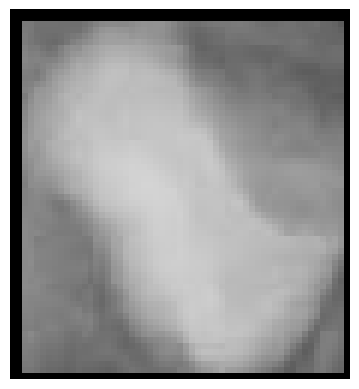

In [ ]:
# Coordinates of the rectangle's top-left and bottom-right corners
top_left_corner = (tooth_bbox[1], tooth_bbox[0])  # Replace x1, y1 with actual coordinates
bottom_right_corner = (tooth_bbox[3], tooth_bbox[2])  # Replace x2, y2 with actual coordinates

# Crop the image to the bounding box
cropped_image = im[top_left_corner[1]:bottom_right_corner[1], top_left_corner[0]:bottom_right_corner[0]]

# Display the cropped image using plt in single-channel grayscale
plt.imshow(cropped_image, cmap='gray')
plt.axis("off")

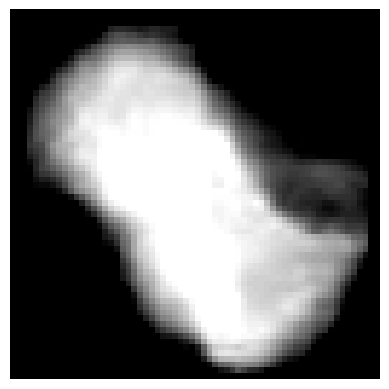

In [ ]:
# Normalize the image pixel values by cropped image average and std to account for local brightness and contrast differences

resized_image = cv2.resize(cropped_image, (64, 64))

mean = np.mean(resized_image)
std = np.std(resized_image)
normalized_image = (resized_image - mean) / std

plt.axis("off")
# Display the normalized image using plt in single-channel grayscale
plt.imshow(normalized_image, cmap='gray')

In [ ]:
import torch
from torchvision import transforms


In [ ]:
import os
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

# Path to the directory containing radiograph images
radiographs_dir = '/content/drive/MyDrive/cse493-final/Tufts Dental Database/Radiographs/'
masks_dir = '/content/drive/MyDrive/cse493-final/Tufts Dental Database/Expert/mask/'

# Path to the directory containing bounding box data
bbox_file_path = '/content/drive/MyDrive/cse493-final/Tufts Dental Database/Segmentation/teeth_bbox.json'

# Directory to save labeled cropped images
output_img_dir = '/content/drive/MyDrive/cse493-final/Tufts Dental Database/Labeled_Cropped_Images_V2/'
# Directory to save labeled cropped masks
output_mask_dir = '/content/drive/MyDrive/cse493-final/Tufts Dental Database/Labeled_Cropped_Masks_V2/'

# Create the output directory if it doesn't exist
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Load bounding box data from the JSON file
with open(bbox_file_path) as f:
    bboxes_data = json.load(f)
################################################################




In [ ]:
import numpy as np
from PIL import Image

In [ ]:
i = 0
total_h = total_w = 0
# Define the target size
std_threshold = 1e-10
error = 0
success_count = 0 # how many croppings we get per x-ray image
total_success_count = 0 # total number of croppings
# Process the first two radiographs (or remove [:2] to process all)
for bbox_entry in bboxes_data:  # Selecting only the first two radiographs
    image_id = bbox_entry['External ID'].split(".")[0]
    tooth_bboxes = bbox_entry['Label']['objects']

    # Load the corresponding radiograph image
    image_path = os.path.join(radiographs_dir, f"{image_id}.JPG")
    mask_path = os.path.join(masks_dir, f"{image_id}.JPG")
    print(f"Loaded Image: {image_path} ")
    print(f"Loaded Mask: {mask_path}")

    # Check if the image file exists
    if not os.path.isfile(image_path):
        print(f"Image not found: {image_path}")
        continue

    # Read the image
    im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image was loaded successfully
    if im is None or mask is None:
        print(f"Error reading image/mask: {image_id}")
        continue

    count = 0
    # Process each tooth bounding box in the radiograph
    for idx, tooth_bbox_info in enumerate(tooth_bboxes, start=1):
        tooth_bbox = tooth_bbox_info['bounding box']
        # print(f"print bbox: {tooth_bbox}")
        title = tooth_bbox_info['title']

        # Extract coordinates
        y1, x1, y2, x2 = tooth_bbox  # Reversed order due to y1,x1,y2,x2 format

        # Display the image using plt in single-channel grayscale
        # plt.imshow(im, cmap='gray')

        # Crop the tooth from the radiograph
        cropped_image = im[y1:y2, x1:x2]  # Adjusted cropping order
        cropped_mask = mask[y1:y2, x1:x2]

        # Check if the cropped image is valid before resizing
        if cropped_image is None or cropped_image.size == 0:
            print(f"Invalid cropped image for tooth: {image_id}-{title}")
            continue

        # Resize the cropped image to the target size before normalization
        resized_cropped_image = cv2.resize(cropped_image, (56,140))
        resized_cropped_mask = cv2.resize(cropped_mask, (56,140))

        # Normalize the resized image
        mean = np.mean(resized_cropped_image)
        std = np.std(resized_cropped_image)
        count += 1
        # Check for very low standard deviation to avoid issues
        if (std < std_threshold) or (cropped_image.size < 16) :
            print(f"Low standard deviation encountered for tooth: {image_id}-{title}")
            print(f"Error count: {error}")
            std = 1  # Replace zero std with 1 for stability
            error+=1
        else:
            #normalized_image = (resized_cropped_image - mean) / std

            i += 1
            total_h += (y2-y1)
            total_w += (x2-x1)


            # Define the filename with external ID and tooth title
            filename = f"{image_id}-{idx}.JPG"
            '''print(f"tooth number:  {count} ")
            print(f"tooth file name: {filename} ")'''

            # Save the normalized image to the output directory
            save_img_path = os.path.join(output_img_dir, filename)
            save_mask_path = os.path.join(output_mask_dir, filename)


            rgb_img = np.zeros((3, 140, 56))
            rgb_img += resized_cropped_image
            rgb_img = rgb_img.transpose(1, 2, 0)

            # Display the normalized image
            # plt.imshow(resized_cropped_image, cmap='gray')
            # plt.axis("off")
            # plt.show()
            # plt.imshow(resized_cropped_mask, cmap='gray')
            # plt.axis("off")
            # plt.show()


            cv2.imwrite(save_img_path, rgb_img)
            cv2.imwrite(save_mask_path, resized_cropped_mask)
            success_count+=1
            total_success_count +=1
    print(f"successfully saved masks for image: {success_count}")
    success_count = 0


print("Completed.")
print(f"Total error images: {error}")
print(f"Total croppings: {total_success_count}")


Loaded Image: /content/drive/MyDrive/cse493-final/Tufts Dental Database/Radiographs/797.JPG 
Loaded Mask: /content/drive/MyDrive/cse493-final/Tufts Dental Database/Expert/mask/797.JPG
Low standard deviation encountered for tooth: 797-4
Error count: 0
Low standard deviation encountered for tooth: 797-10
Error count: 1
Low standard deviation encountered for tooth: 797-15
Error count: 2
Low standard deviation encountered for tooth: 797-21
Error count: 3
Low standard deviation encountered for tooth: 797-22
Error count: 4
Low standard deviation encountered for tooth: 797-23
Error count: 5
successfully saved masks for image: 25
Loaded Image: /content/drive/MyDrive/cse493-final/Tufts Dental Database/Radiographs/909.JPG 
Loaded Mask: /content/drive/MyDrive/cse493-final/Tufts Dental Database/Expert/mask/909.JPG
successfully saved masks for image: 19
Loaded Image: /content/drive/MyDrive/cse493-final/Tufts Dental Database/Radiographs/135.JPG 
Loaded Mask: /content/drive/MyDrive/cse493-final/Tufts

In [ ]:
total_h / i, total_w / i

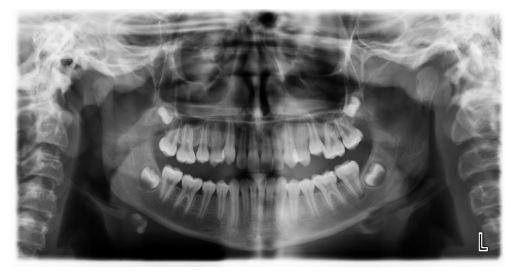

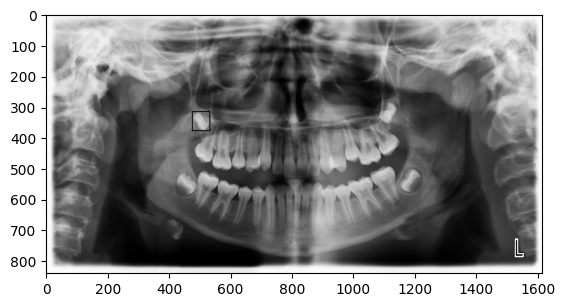

In [ ]:
# Read the image using matplotlib.image
im = cv2.imread(f"/content/drive/MyDrive/cse493-final/Tufts Dental Database/Radiographs/797.JPG", cv2.IMREAD_GRAYSCALE)
# Display the image with interactive features (pan/zoom)
plt.figure()
plt.imshow(im, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

# Check if image is loaded properly
if im is None:
    print("Error: Could not read the image.")
else:
    # Coordinates of the rectangle's top-left and bottom-right corners
    top_left_corner = (tooth_bbox[1], tooth_bbox[0])  # Replace x1, y1 with actual coordinates
    bottom_right_corner = (tooth_bbox[3], tooth_bbox[2])  # Replace x2, y2 with actual coordinates

    # Draw a black rectangle on the image
    cv2.rectangle(im, top_left_corner, bottom_right_corner, 0, 2)

    # Display the image using plt in single-channel grayscale
    plt.imshow(im, cmap='gray')